In this file, two different machine learning models will be developed and trained to predict machine failure based on different feautures.

The dataset is taken from https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset and will include following features:

- Air temperature [K]

- Process temperature [K]

- Rotational speed [RPM]

- Torque [Nm]

- Tool wear [min]

The target variable will be 0 (no failure) and 1 (failure) to indicate the prediction of machine failure.

The chosen machine learning models will be logistic regression and random forest.

We start by importing the necessary libraries and loading the data. We will be using pandas for data handling/processing, seaborn and matplotlib for visualizations and sklearn for the machine learning models

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
data = pd.read_csv(url)

Now we check the data for null values. If any values are null, we delete the entire row.

In [ ]:
print("Checking for null values...")
print(data.isnull().sum())  # Prints the number of null values in each column
data.dropna(inplace=True)  # Removes rows containg null values
print("After removing null values, data shape:", data.shape)

Checking for null values...
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64
After removing null values, data shape: (10000, 14)


We then plot a heatmap so get a visualization of the correlation between the 5 different features that will be used later in our models.

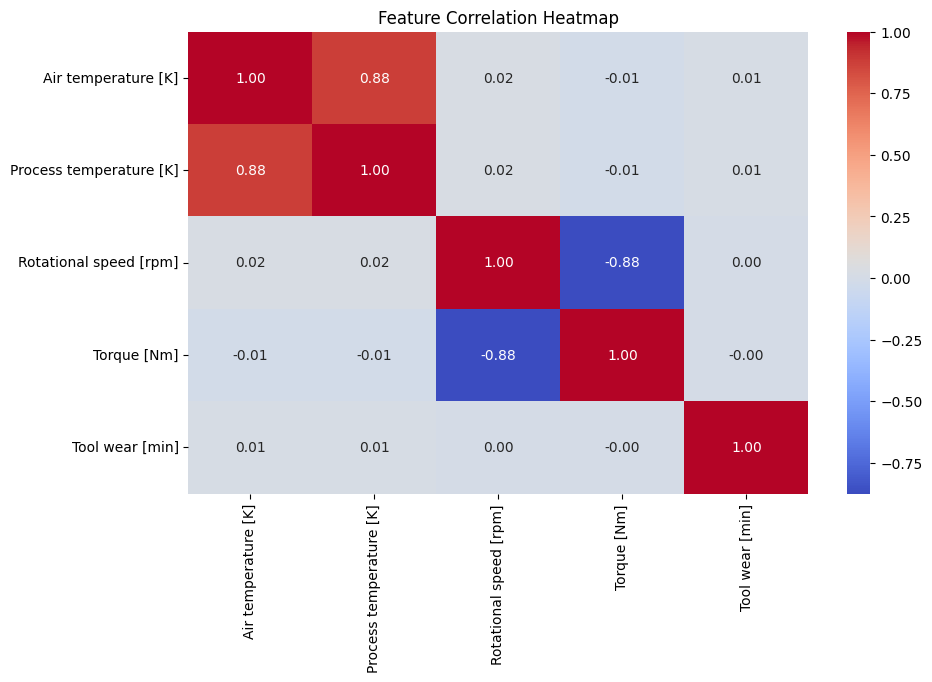

In [ ]:
#Define a list for feature names and values
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
            'Torque [Nm]', 'Tool wear [min]']

numeric_data = data[features]

#Calculates (pearson) correlation using pandas function .corr() and plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

We define a feature value list and a target value list

In [49]:
X = data[features]  # list of feature values
y = data['Machine failure']  # list of target values

We split the data in 5 sets using Stratified k-folding and initialize an accumulated list of the metrics of each model, and confusion matrix for each model

In [50]:
# Initializing StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accumulators for metrics and confusion matrices
accumulated_metrics_LR = []
accumulated_metrics_RF = []
conf_matrix_LR = None
conf_matrix_RF = None

We will now train both models on all of the five fold, calculate the metrics and store them in their respective metrics list. The TP, FP, TN and FN results is also accumulated in the confusion matrix, so an average confusion matrix of the results can be created later.

The two models will also use the "class_weight='balanced'" to handle the class imbalance in the dataset.

In [ ]:
# Iterate through the Stratified K-Folds
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Initialize the model, trains the model on the training data set and then make predictions on the test set (Logistic Regression)
    modelLR = LogisticRegression(class_weight='balanced', random_state=42)
    modelLR.fit(X_train, y_train)
    y_predLR = modelLR.predict(X_test)
    
    # Initialize the model, trains the model on the training data set and then make predictions on the test set (Random Forests)
    modelRFC = RandomForestClassifier(class_weight='balanced', random_state=42)
    modelRFC.fit(X_train, y_train)
    y_predRFC = modelRFC.predict(X_test)
    
    # Takes the predictions from the test set and the model prediction results and calculate metrics. Then it appends them  to metrics list (logistic regression)
    accumulated_metrics_LR.append({
        "accuracy": accuracy_score(y_test, y_predLR),
        "precision": precision_score(y_test, y_predLR),
        "recall": recall_score(y_test, y_predLR),
        "f1": f1_score(y_test, y_predLR)
    })
    
    # Takes the predictions from the test set and the model prediction results and calculate metrics. Then it appends them  to metrics list (random forests)
    accumulated_metrics_RF.append({
        "accuracy": accuracy_score(y_test, y_predRFC),
        "precision": precision_score(y_test, y_predRFC),
        "recall": recall_score(y_test, y_predRFC),
        "f1": f1_score(y_test, y_predRFC)
    })
    
    # Calculates confusion matrics based on the test set and model prediction results and store them
    if conf_matrix_LR is None:
        conf_matrix_LR = confusion_matrix(y_test, y_predLR)
        conf_matrix_RF = confusion_matrix(y_test, y_predRFC)
    else:
        conf_matrix_LR += confusion_matrix(y_test, y_predLR)
        conf_matrix_RF += confusion_matrix(y_test, y_predRFC)




We can now compute the average of our metric values.

In [ ]:
# Compute average metrics and store them in metrics_df
metrics_summary = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [sum(m["accuracy"] for m in accumulated_metrics_LR) / len(accumulated_metrics_LR),
                 sum(m["accuracy"] for m in accumulated_metrics_RF) / len(accumulated_metrics_RF)],
    "Precision": [sum(m["precision"] for m in accumulated_metrics_LR) / len(accumulated_metrics_LR),
                  sum(m["precision"] for m in accumulated_metrics_RF) / len(accumulated_metrics_RF)],
    "Recall": [sum(m["recall"] for m in accumulated_metrics_LR) / len(accumulated_metrics_LR),
               sum(m["recall"] for m in accumulated_metrics_RF) / len(accumulated_metrics_RF)],
    "F1-Score": [sum(m["f1"] for m in accumulated_metrics_LR) / len(accumulated_metrics_LR),
                 sum(m["f1"] for m in accumulated_metrics_RF) / len(accumulated_metrics_RF)]
}

metrics_df = pd.DataFrame(metrics_summary)



Now we want to evaluate the performance of the models. We make a confusion matrix of the average metrics.

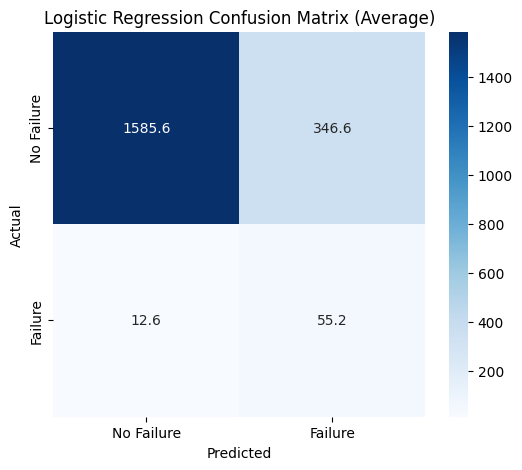

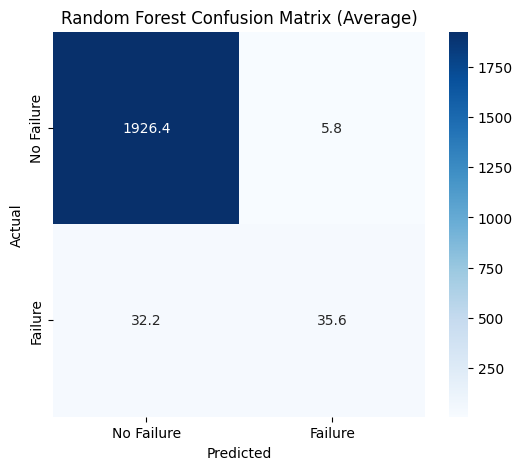

In [53]:
# Plot average confusion matrix for Logistic Regression
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_LR / 5, annot=True, fmt=".1f", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix (Average)")
plt.show()

# Plot average confusion matrix for Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_RF / 5, annot=True, fmt=".1f", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (Average)")
plt.show()



and a bar chart for the validation metrics


Validation Metrics Summary:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression    0.8204   0.137526  0.814091  0.235189
1        Random Forest    0.9810   0.863015  0.525154  0.651694


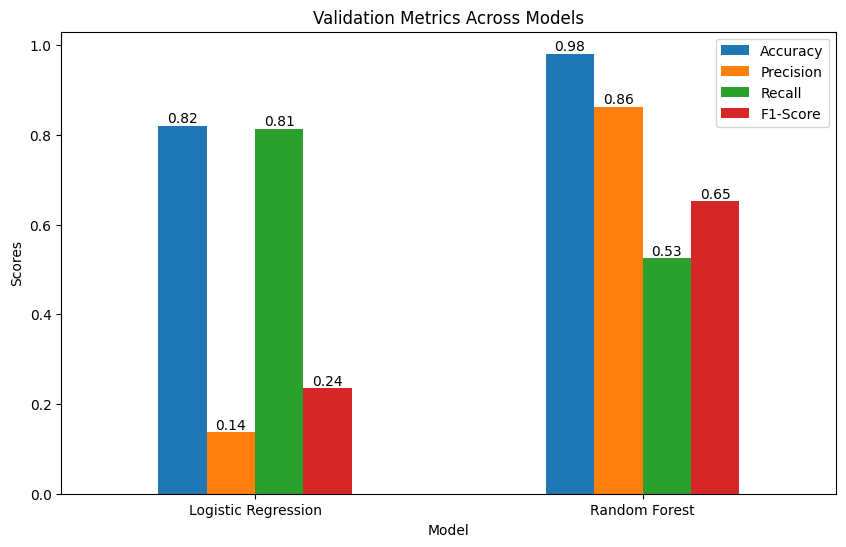

In [54]:
# Print the average metric values
print("\nValidation Metrics Summary:")
print(metrics_df)

# Visualize metrics as a bar chart
ax = metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.title("Validation Metrics Across Models")
plt.ylabel("Scores")
plt.xticks(rotation=0)
plt.legend(loc="best")

# Annotate bars with metric values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 5), textcoords="offset points", ha="center", va="center")

plt.show()

and a precision-recall curve

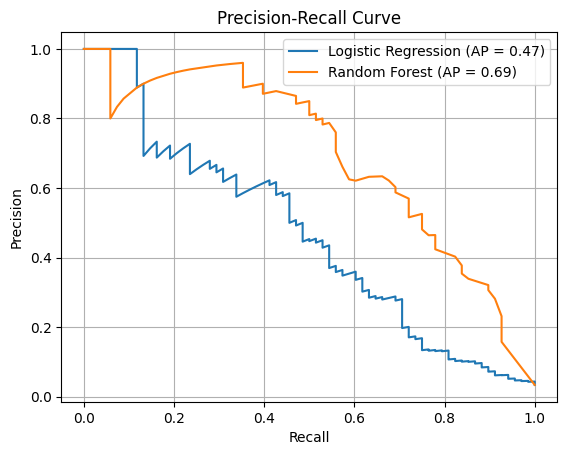

Logistic Regression Average Precision: 0.47
Random Forest Average Precision: 0.69


In [ ]:
# Predicts probability for the positive class for all test samples (logistic regression).
y_prob_LR = modelLR.predict_proba(X_test)[:, 1]

# Calculate the precision and recall value to be used for the PR curve (Logistic regression)
precision_LR, recall_LR, _ = precision_recall_curve(y_test, y_prob_LR)
ap_LR = average_precision_score(y_test, y_prob_LR)

# Plotting PR curve for logistic regression
plt.plot(recall_LR, precision_LR, label=f"Logistic Regression (AP = {ap_LR:.2f})")

# Predicts probability for the positive class for all test samples (Random Forests)
y_prob_RF = modelRFC.predict_proba(X_test)[:, 1] 

# Calculate the precision and recall value to be used for the PR cruve (Random Forests)
precision_RF, recall_RF, _ = precision_recall_curve(y_test, y_prob_RF)
ap_RF = average_precision_score(y_test, y_prob_RF)

# Plotting PR curve for random forests
plt.plot(recall_RF, precision_RF, label=f"Random Forest (AP = {ap_RF:.2f})")

# Configuration of curve display
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()

# Print values for average precision for logistic regression and random forests
print(f"Logistic Regression Average Precision: {ap_LR:.2f}")
print(f"Random Forest Average Precision: {ap_RF:.2f}")